<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Inference__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model (HMM) State Inference
The **HMM_Inference** class includes the methods listed below which are capable of inferring from batched samples and are implemented from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html):


1.   Forward-Backwards algorithm
2.   The Viterbi algorithm


This notebook contains examples for HMM with Categorical and Gaussian emission distributions.

Any arbitrary emission distribution (Categorical, Normal, Poisson, etc.) is permitted as long as it contains a **log_prob** and **sample** method (see [TensorFlow Probability Distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution)).

1. **Forward-Backwards Algorithm** <br><br>
Given the state transition matrix, emission distribution, and intial state probability vector: $\theta=(A, B, \pi)$, the filtering (Forwards) and smoothing (Backwards) operations are as follows:
\begin{align*}
\boldsymbol\alpha_t&= \Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{t}, \boldsymbol\theta)\\
&= \text{normalize}( \boldsymbol \lambda_t  \odot (A^\top \boldsymbol \alpha_{t-1}))\\ \\
\boldsymbol \gamma_t &=\Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{N}, \boldsymbol\theta)\\
&= \text{normalize}(\boldsymbol\alpha_t \odot \boldsymbol\beta_t)
\end{align*}
where
\begin{align*}
\boldsymbol \lambda_t &= \Pr(\mathbf y_t|\mathbf z_t)\\
\boldsymbol\beta_{t-1}&=\Pr(\mathbf y_1\cdots \mathbf y_t|\mathbf z_t)\\
&= A( \boldsymbol \lambda_t \odot \boldsymbol\beta_t)
\end{align*}
The base case for the algorithms are:
\begin{align*}
\boldsymbol \alpha_0&=\boldsymbol \pi \\
\boldsymbol\beta_N &= \boldsymbol 1
\end{align*}
The two-slice smoothed marginals are also computed as follows:
\begin{align*}
\boldsymbol \xi_{t, t+1} &= \Pr(\mathbf z_t, \mathbf z_{t+1}|\mathbf y_1\cdots \mathbf y_N)\\
&= \frac{A\odot [\boldsymbol \alpha_t(\boldsymbol \lambda_{t+1}\odot \boldsymbol \beta_{t+1})^\top]}{\Pr(\mathbf y_{t+1}\cdots \mathbf y_N|\mathbf y_1\cdots \mathbf y_{t})}
\end{align*}
Note that the denominator above is also the normalizing constant used in computing $\boldsymbol \alpha_t$.
<br><br>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## HMM Inference Class

In [7]:
class HMM_Inference:
  def __call__ (self, transition_distribution, emission_distribution, emission_params, initial_distribution, observations):
    batch_dims, num_steps, num_states = observations.shape[0], observations.shape[1], transition_distribution.shape[0]
    emission_model = emission_distribution(emission_params)
    local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
    filtered, filtered_Z = self.Forward(transition_distribution, initial_distribution, local_evidence)
    smoothed, beta = self.Backward(filtered, filtered_Z, transition_distribution, local_evidence, batch_dims, num_steps, num_states)
    two_slice_marginals = self.marginals(filtered[:, 1:], beta[:, 1:], transition_distribution, local_evidence)
    states_Viterbi = self.Viterbi(transition_distribution, initial_distribution, local_evidence, batch_dims, num_steps, num_states)
    return filtered[:, :-1], filtered_Z, smoothed[:, 1:], beta[:, 1:], two_slice_marginals, states_Viterbi

  def normalizing_constant(self, x):
    return tf.reduce_sum(x, -2, keepdims=True)

  @tf.function
  def Forward(self, transition_distribution, initial_distribution, local_evidence):
    filtered = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_Z = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_t = tf.broadcast_to(initial_distribution, local_evidence[:, 0].shape)
    filtered_Z_t = self.normalizing_constant(filtered_t)
    filtered_t = filtered_t / filtered_Z_t
    filtered = filtered.write(0, filtered_t)
    for i in tf.range(num_steps):
      filtered_t = local_evidence[:, i] * (tf.transpose(transition_distribution) @ filtered_t)
      filtered_Z_t = self.normalizing_constant(filtered_t)
      filtered_t = filtered_t / filtered_Z_t
      filtered = filtered.write(i + 1, filtered_t)
      filtered_Z = filtered_Z.write(i, filtered_Z_t)
    return tf.transpose(filtered.stack(), [1, 0, 2, 3]), tf.transpose(filtered_Z.stack(), [1, 0, 2, 3])

  @tf.function
  def Backward(self, filtered, filtered_Z, transition_distribution, local_evidence, batch_dims, num_steps, num_states):
    beta = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    beta_t = tf.fill([batch_dims, num_states, 1], 1.)
    beta = beta.write(num_steps, beta_t)
    for i in tf.range(num_steps - 1, -1, -1):
      beta_t = transition_distribution @ (local_evidence[:, i] * beta_t)
      beta_t = beta_t / filtered_Z[:, i]
      beta = beta.write(i, beta_t)  
    beta = tf.transpose(beta.stack(), [1, 0, 2, 3])
    smoothed = filtered * beta
    smoothed = smoothed / self.normalizing_constant(smoothed)
    return smoothed, beta

  @tf.function
  def marginals(self, filtered, beta, transition_distribution, local_evidence):
    shifted_filtered = filtered[:, :-1]
    shifted_beta = beta[:, 1:]
    shifted_local_evidence = local_evidence[:, 1:]
    unormalized_two_slice_marginals = transition_distribution * (shifted_filtered @ tf.transpose(shifted_local_evidence * shifted_beta, [0, 1, 3, 2]) )
    two_slice_marginals_Z = tf.reduce_sum(tf.reduce_sum(unormalized_two_slice_marginals, -1), -1, keepdims=True)
    return unormalized_two_slice_marginals / tf.broadcast_to(two_slice_marginals_Z[..., tf.newaxis], unormalized_two_slice_marginals.shape)

  @tf.function
  def Viterbi(self, transition_distribution, initial_distribution, local_evidence, batch_dims, num_steps, num_states):
    node = tf.TensorArray(tf.int64, size=0, dynamic_size=True)
    MAP_path = tf.TensorArray(tf.int64, size=0, dynamic_size=True)
    log_max_prob = - tf.math.log(local_evidence[:, 0]) - tf.math.log(initial_distribution)
    log_local_evidence = - tf.math.log(tf.transpose(local_evidence, [0, 1, 3, 2]))
    log_local_evidence = tf.tile(log_local_evidence, [1, batch_dims, num_states, 1]) 
    log_transition_distribution = - tf.math.log(tf.transpose(transition_distribution))
    for i in tf.range(1, num_steps):
      log_probs = log_transition_distribution + log_local_evidence[:, i] + tf.tile(tf.transpose(log_max_prob, [0, 2, 1]), [1, num_states, 1])
      min_index = tf.math.argmin(log_probs, 2)[..., tf.newaxis]
      log_max_prob = tf.gather_nd(log_probs, min_index, 2)[..., tf.newaxis]
      node = node.write(i, min_index)
    node = tf.transpose(node.stack(), [1, 0, 2, 3])
    state_t = tf.math.argmin(tf.reshape(log_probs, [batch_dims, num_states * num_states]), 1)
    state_t = tf.cast(state_t/num_states, tf.int64)[..., tf.newaxis]
    MAP_path = MAP_path.write(0, state_t)
    for i in tf.range(num_steps - 2, -1, -1):
      state_t = tf.gather(node[:, i, :, 0], state_t[..., 0], axis=1, batch_dims=1)[..., tf.newaxis]
      MAP_path = MAP_path.write(i + 1, state_t)
    return tf.transpose(MAP_path.stack(), [1, 0, 2])

## HMM Observations Generator

In [21]:
@tf.function
def HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(states_probs_0)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=transition_matrix).sample([batch_dims, steps])
  observation_distribution = emission_distribution(emission_params).sample([batch_dims, steps])
  state = tf.TensorArray(state_t.dtype, size=0, dynamic_size=True)
  obs = tf.TensorArray(observation_distribution.dtype, size=0, dynamic_size=True, clear_after_read=False)
  for i in tf.range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    state = state.write(i, state_t)
    obs = obs.write(i, obs_t)
  obs_correct_dims = tf.concat([tf.constant([1, 0]), tf.range(2, tf.size(obs_t.shape) + 1)], 0)
  return tf.transpose(state.stack(), [1, 0, 2]), tf.transpose(obs.stack(), obs_correct_dims)

# Example 1. Casino Dice Roll State Inference

## Set HMM Parameters

In [14]:
num_states = 3

initial_distribution = tf.fill([num_states, 1], 1/num_states)

transition_distribution = tf.constant([
    [0.95, 0.025, 0.025], 
    [0.07, 0.9, 0.03],
    [0.07, 0.03, 0.9]
])

emission_params = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([1/10, 1/10, 1/10, 5/10, 1/10, 1/10]),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

emission_distribution = tf.keras.layers.Lambda(lambda arg: tfd.Categorical(probs=arg))

tf.print('Transition Distribution:\n{}\n\nEmission Distribution\n{}\n\nEmission Parameters\n{}'.format(
    transition_distribution, emission_distribution(emission_params), emission_params))

Transition Distribution:
[[0.95  0.025 0.025]
 [0.07  0.9   0.03 ]
 [0.07  0.03  0.9  ]]

Emission Distribution
tfp.distributions.Categorical("Categorical", batch_shape=[3], event_shape=[], dtype=int32)

Emission Parameters
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.5        0.1        0.1       ]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]


## Generate Sample Data

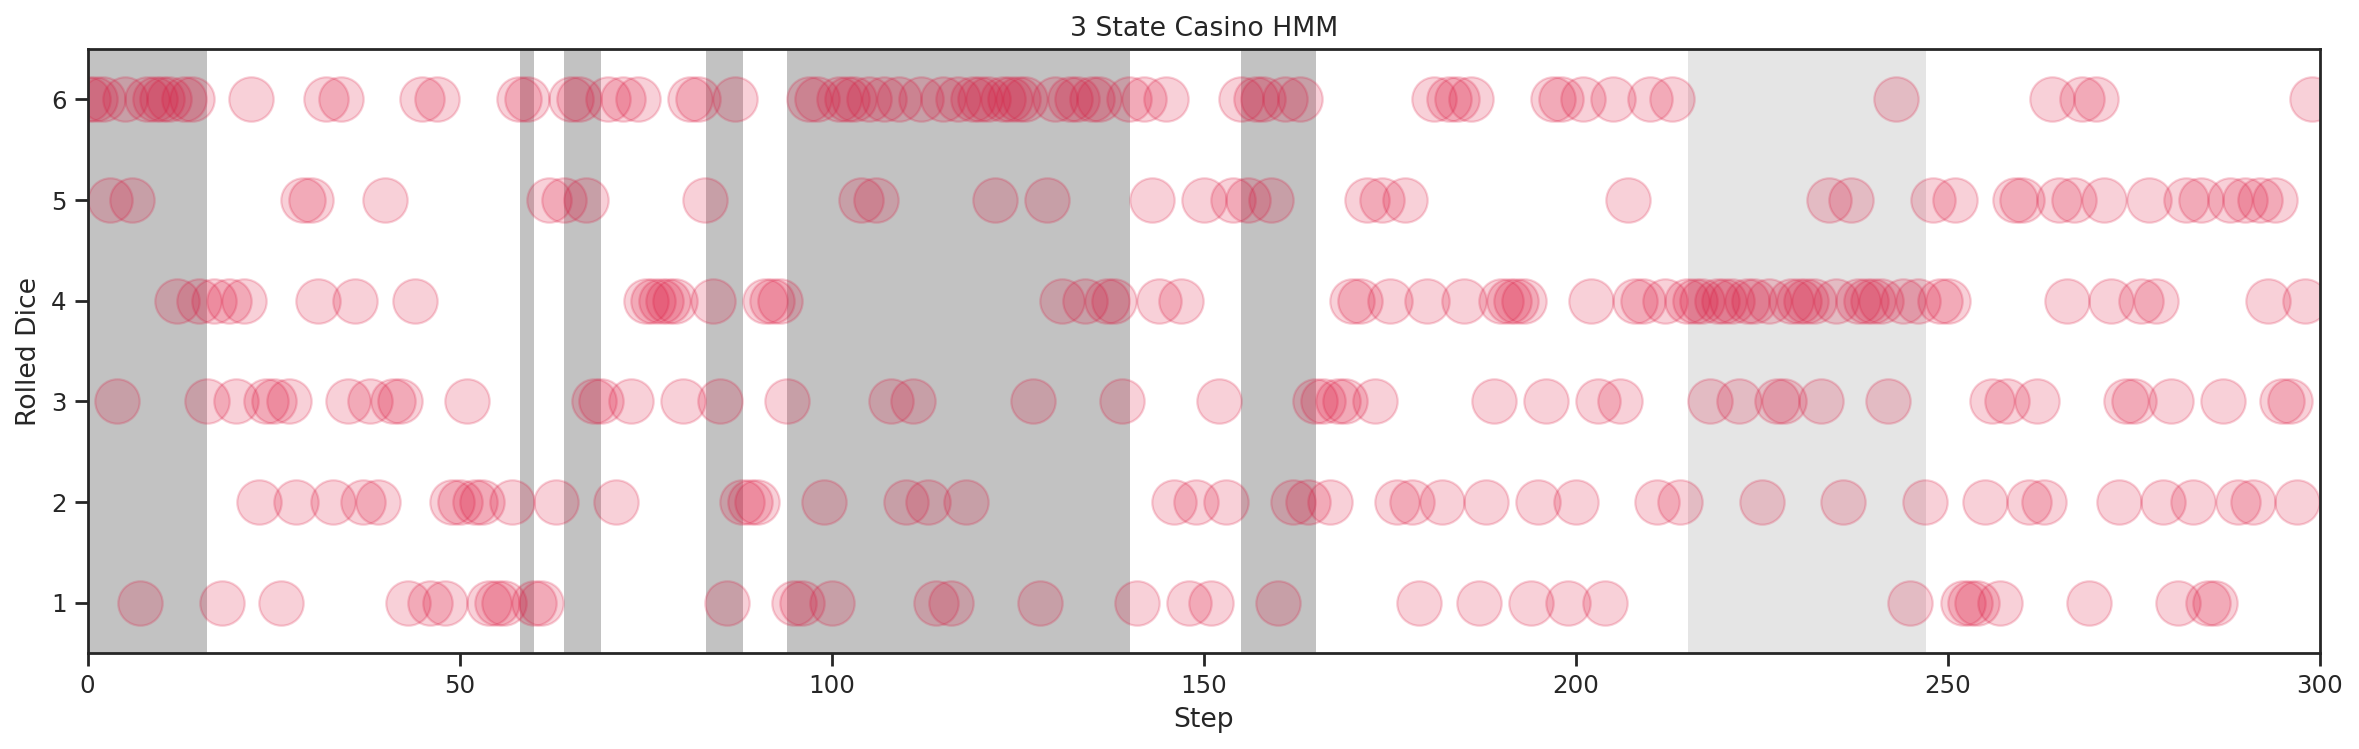

In [31]:
num_batches = 1
num_steps = 300
true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
plt.figure(figsize=(18, 5))
plt.imshow(true_states[None, 0, :, 0], extent=(0, num_steps, 0, 7), cmap='Greys', alpha=0.24, aspect='auto')
plt.scatter(tf.range(num_steps), observations[0] + 1, color="crimson", alpha=0.2, s=400)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.ylim(0.5, 6.5); plt.show()

## Perform State Inference

In [32]:
Inference = HMM_Inference()
filtered, filtered_Z, smoothed, beta, two_slice_marginals, states_Viterbi = Inference(transition_distribution, emission_distribution, emission_params, initial_distribution, observations)

## Results

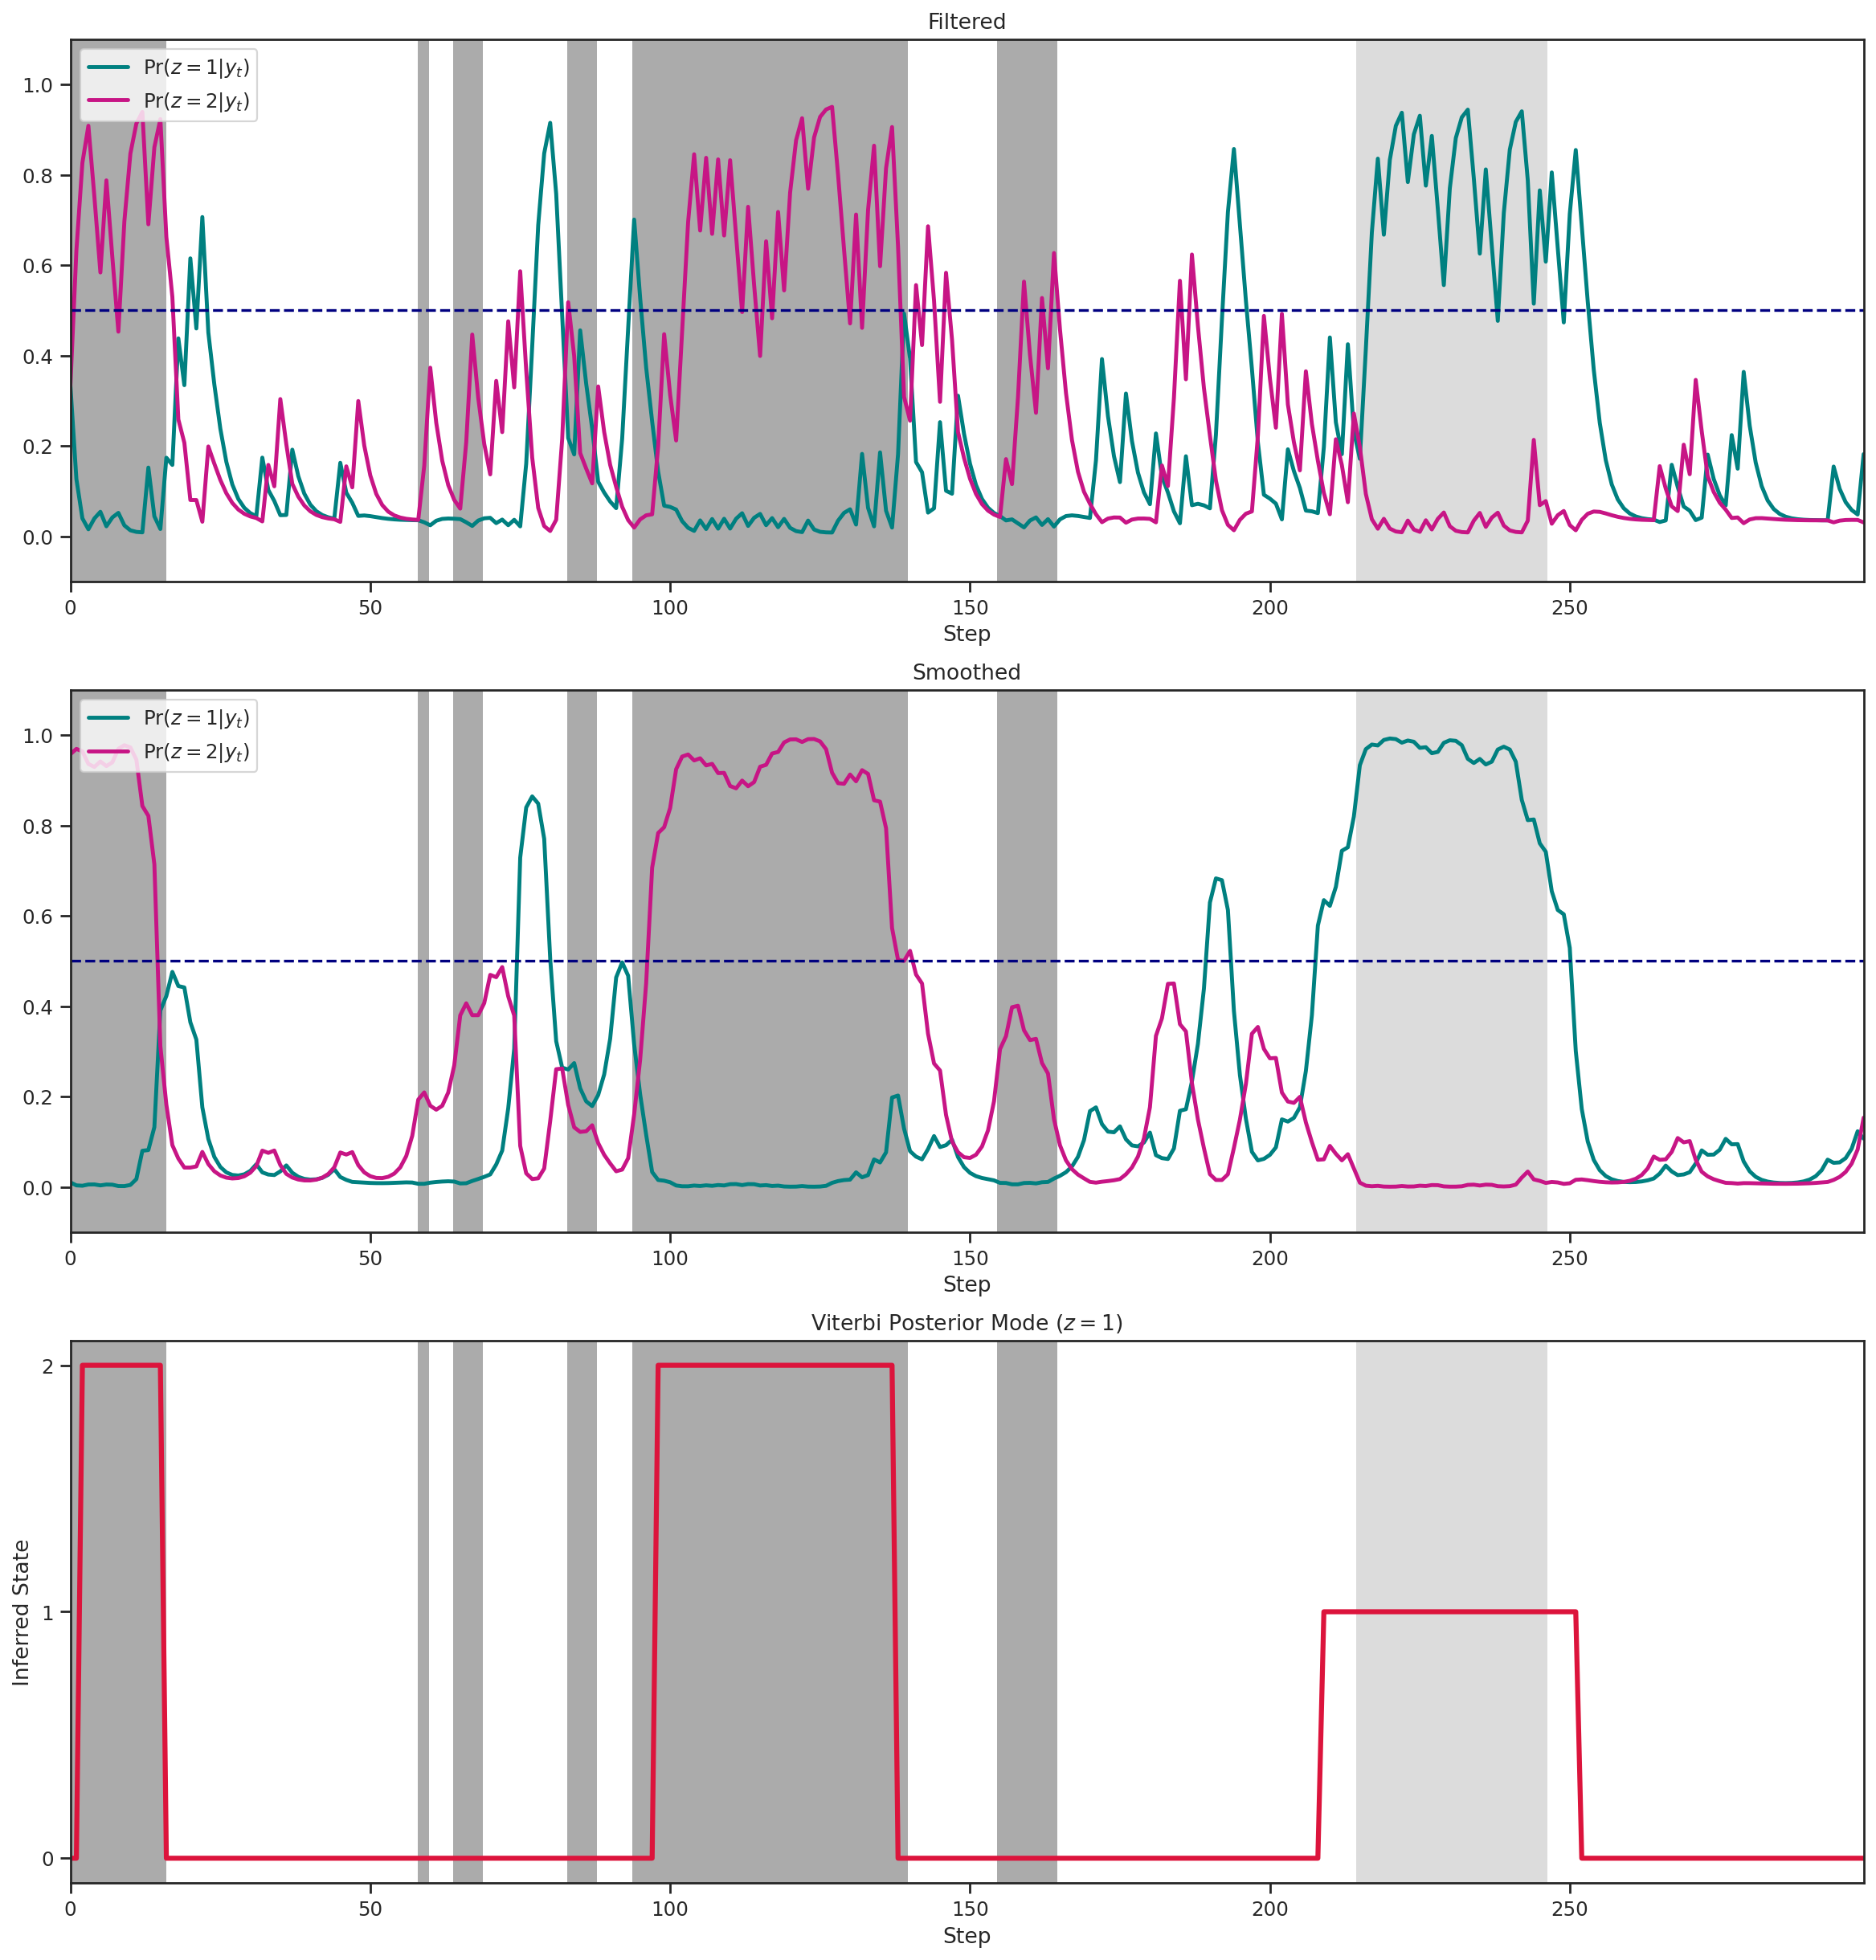

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(18, 19))
title = ['Filtered', 'Smoothed']
data = [filtered[0, :, 1], filtered[0, :, 2], 
        smoothed[0, :, 1], smoothed[0, :, 2]]

for i in range(2):
  axes[i].imshow(true_states[None, 0, :, 0], extent=(0, num_steps - 1, -0.1, 1.1), cmap='Greys', alpha=0.33, aspect='auto')
  axes[i].plot(data[2*i], label='$\Pr(z=1|y_t)$', color='teal', linewidth=2.2)
  axes[i].plot(data[2*i + 1], label='$\Pr(z=2|y_t)$', color='mediumvioletred', linewidth=2.2)
  axes[i].axhline(0.5, color = 'navy', linestyle='--')
  axes[i].set(xlabel='Step', title=title[i])
  axes[i].legend(loc='upper left');

axes[2].plot(states_Viterbi[0, :], color='crimson', linewidth=2.8)
axes[2].imshow(true_states[None, 0, :, 0], extent=(0, num_steps - 1, -0.1, num_states - 0.9), cmap='Greys', alpha=0.33, aspect='auto')
axes[2].set(xlabel='Step', ylabel='Inferred State', title='Viterbi Posterior Mode ($z=1$)', yticks=np.arange(0, 3, 1))
plt.show()

# Example 2. Time Series State Inference

## Set HMM Parameters

In [163]:
num_states = 3
initial_distribution = tf.fill([num_states, 1], 1/num_states)

transition_distribution = tf.constant([
    [0.95, 0.025, 0.025], 
    [0.025, 0.95, 0.025],
    [0.025, 0.025, 0.95]
])
emission_params = [
    [1.0, 3.0, 5.0],
    [2.6, 1.2, 0.71]
]

emission_distribution = tf.keras.layers.Lambda(lambda arg: tfd.Normal(loc=arg[0], scale=arg[1]))

tf.print('Transition Distribution:\n{}\n\nEmission Distribution\n{}\n\nEmission Parameters\n{}'.format(
    transition_distribution, emission_distribution(emission_params), emission_params))

Transition Distribution:
[[0.95  0.025 0.025]
 [0.025 0.95  0.025]
 [0.025 0.025 0.95 ]]

Emission Distribution
tfp.distributions.Normal("Normal", batch_shape=[3], event_shape=[], dtype=float32)

Emission Parameters
[[1.0, 3.0, 5.0], [2.6, 1.2, 0.71]]


## Generate Sample Time Series

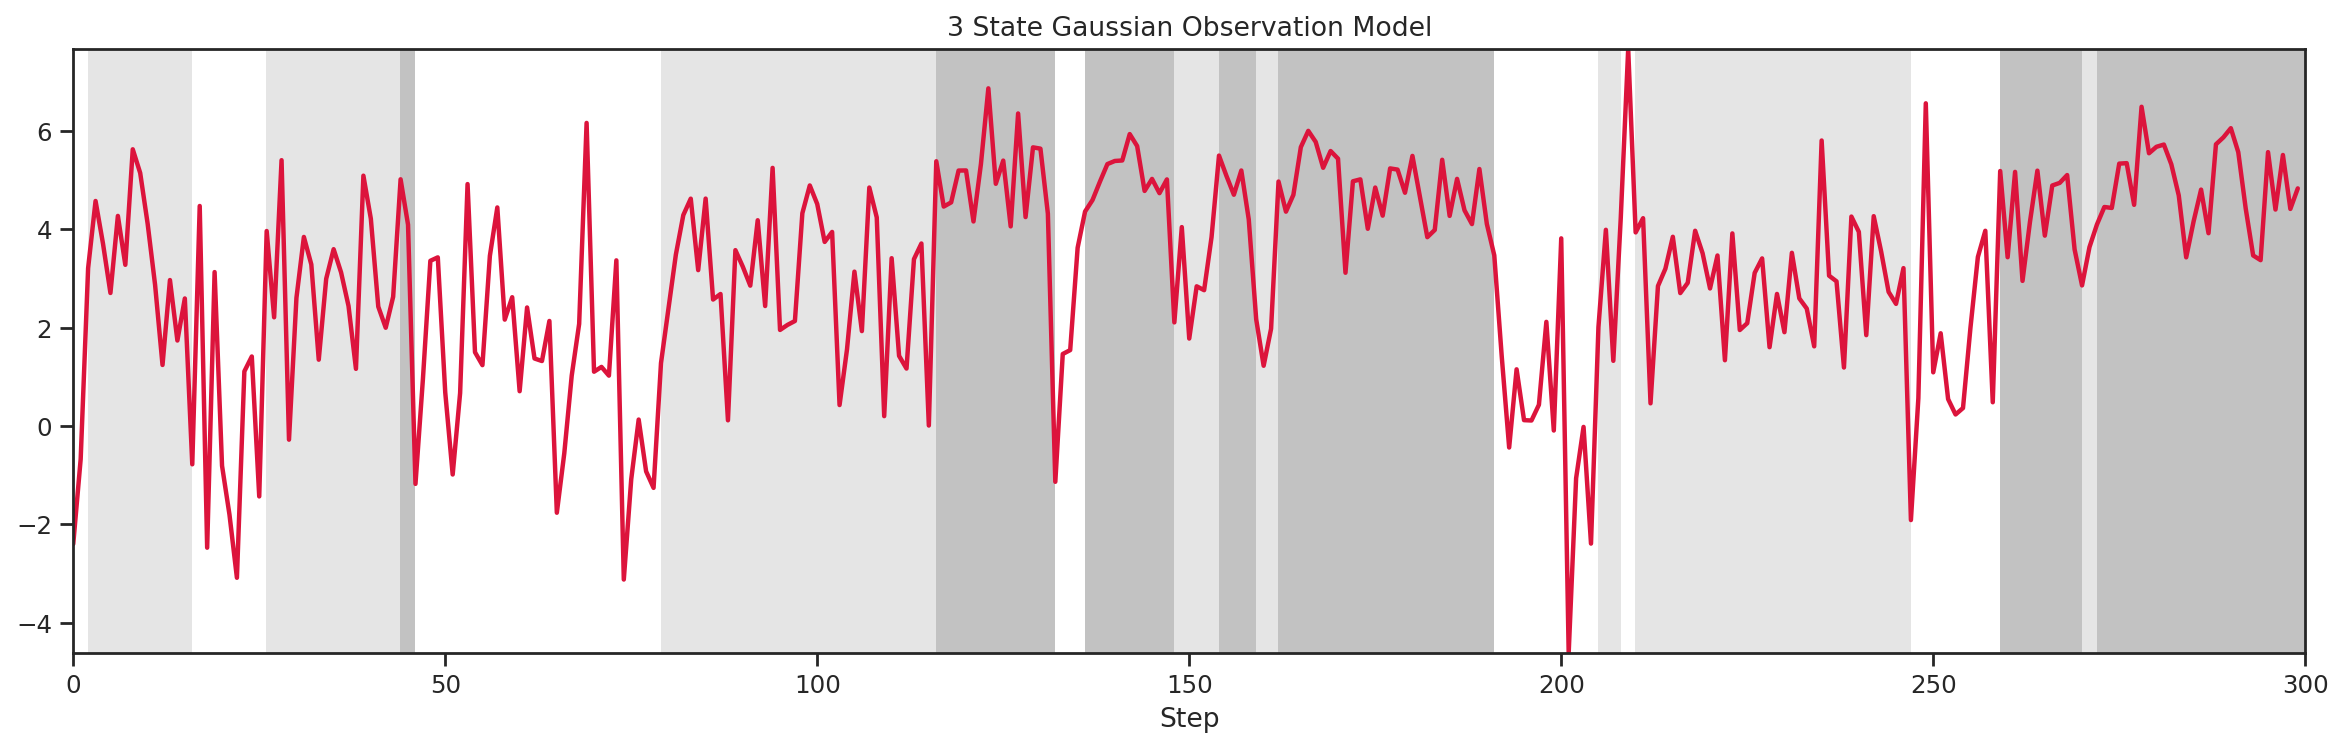

In [165]:
num_batches = 1
num_steps = 300
true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
plt.figure(figsize=(18, 5))
plt.imshow(true_states[None, 0, :, 0], extent=(0, num_steps, np.min(observations[0]), np.max(observations[0])), cmap='Greys', alpha=0.24, aspect='auto')
plt.plot(observations[0], color="crimson", linewidth=2)
plt.title("{} State Gaussian Observation Model".format(num_states));  plt.xlabel('Step'); plt.show()

## Perform State Inference

In [166]:
Inference = HMM_Inference()
filtered, filtered_Z, smoothed, beta, _, states_Viterbi = Inference(transition_distribution, emission_distribution, emission_params, initial_distribution, observations)

## Results

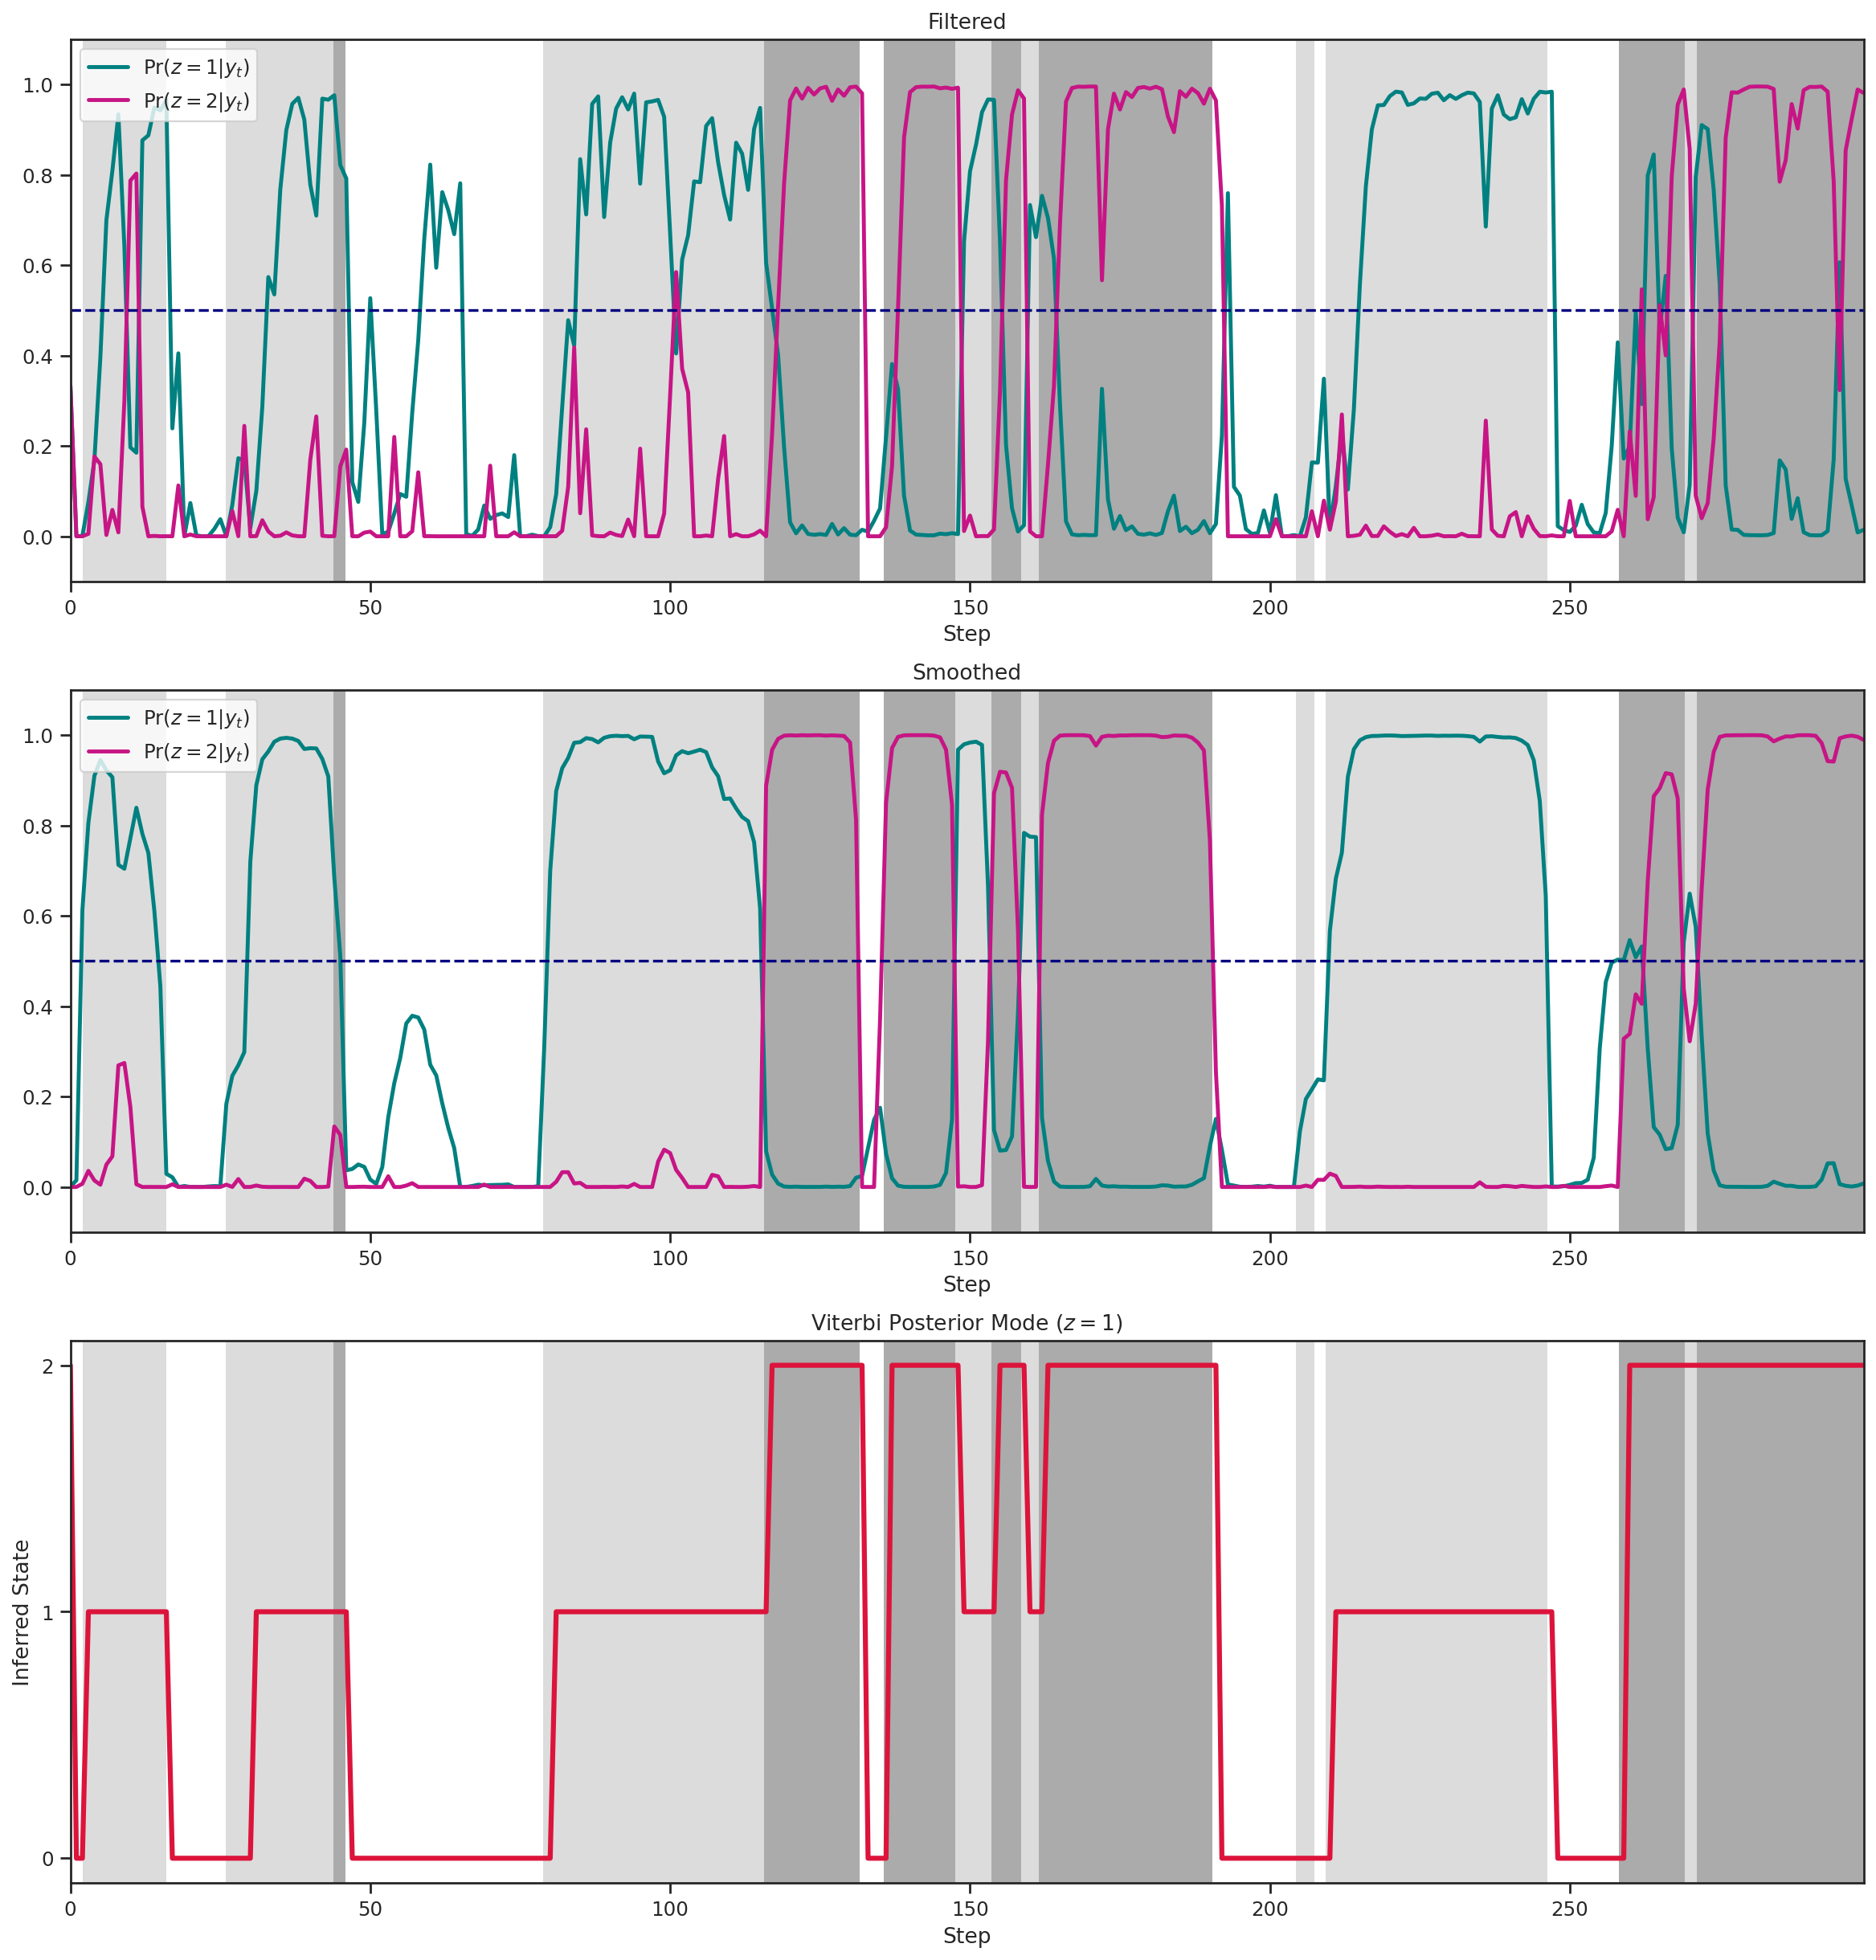

In [167]:
fig, axes = plt.subplots(3, 1, figsize=(18, 19))
title = ['Filtered', 'Smoothed']
data = [filtered[0, :, 1], filtered[0, :, 2], 
        smoothed[0, :, 1], smoothed[0, :, 2]]

for i in range(2):
  axes[i].imshow(true_states[None, 0, :, 0], extent=(0, num_steps - 1, -0.1, 1.1), cmap='Greys', alpha=0.33, aspect='auto')
  axes[i].plot(data[2*i], label='$\Pr(z=1|y_t)$', color='teal', linewidth=2.2)
  axes[i].plot(data[2*i + 1], label='$\Pr(z=2|y_t)$', color='mediumvioletred', linewidth=2.2)
  axes[i].axhline(0.5, color = 'navy', linestyle='--')
  axes[i].set(xlabel='Step', title=title[i])
  axes[i].legend(loc='upper left');

axes[2].plot(states_Viterbi[0], color='crimson', linewidth=2.8)
axes[2].imshow(true_states[None, 0, :, 0], extent=(0, num_steps - 1, -0.1, num_states - 0.9), cmap='Greys', alpha=0.33, aspect='auto')
axes[2].set(xlabel='Step', ylabel='Inferred State', title='Viterbi Posterior Mode ($z=1$)', yticks=np.arange(0, 3, 1))
plt.show()

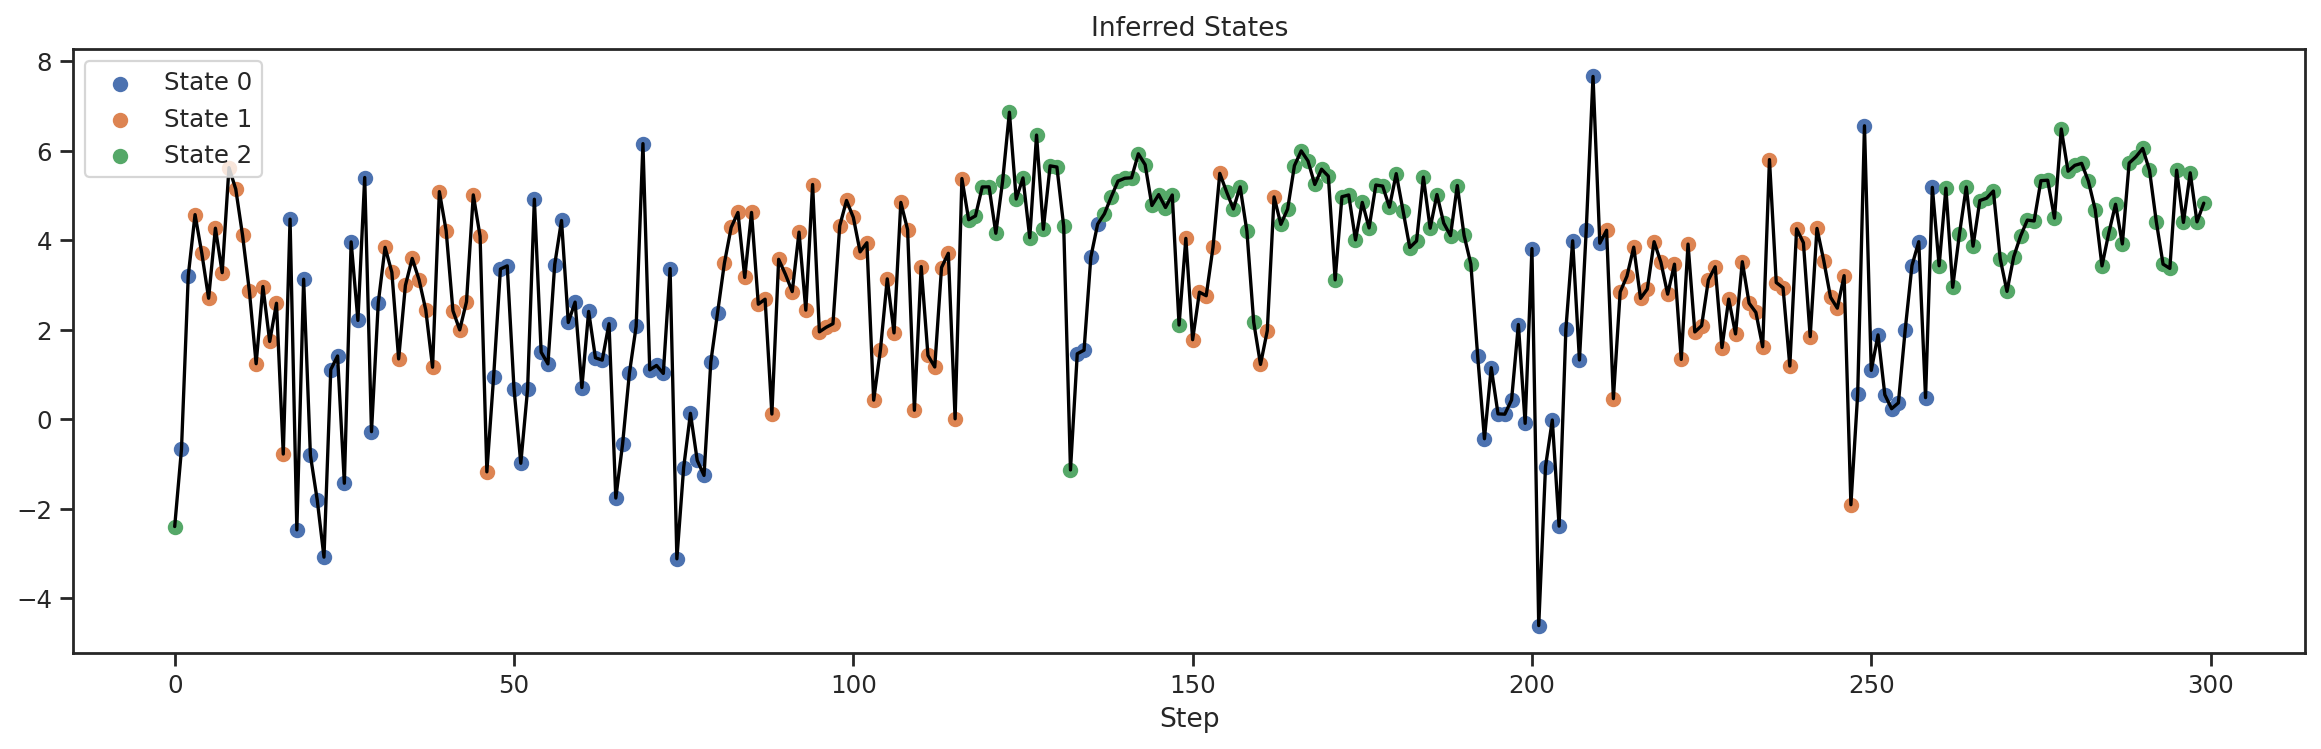

In [169]:
plt.figure(figsize=(18, 5))
plt.plot(observations[0], color="black", linewidth=1.5)
plt.title("Inferred States");  plt.xlabel('Step')
for state in range(3):
  index = tf.where(tf.squeeze(states_Viterbi[0]) == state)
  obs = tf.gather_nd(observations[0], index)
  plt.scatter(index, obs, s=35, label='State {}'.format(state))
  plt.legend(loc='upper left');
plt.show()